In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class MNISTdiscriminator(nn.Module):

  def __init__(self,):
    super().__init__()

    self.des = nn.Sequential(
        nn.Linear(784,1024),
        nn.LeakyReLU(),
        nn.Dropout(0.2,),
        nn.Linear(1024,512),
        nn.LeakyReLU(),
        nn.Dropout(0.2,),
        nn.Linear(512,256),
        nn.LeakyReLU(),
        nn.Dropout(0.2,),
        nn.Linear(256,1),
    )

  def forward(self,x):
    batch_size = x.shape[0]
    x = x.reshape(batch_size,-1)
    out = self.des(x)
    return out

class MINISTgenerator(nn.Module):

  def __init__(self,latent_dim):
    super().__init__()
    self.latent_dim = latent_dim

    self.gen = nn.Sequential(
        nn.Linear(self.latent_dim,512),
        nn.LeakyReLU(),
        nn.Dropout(0.2,),
        nn.Linear(512,1024),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024,784),
        nn.Tanh()
    )

  def forward(self,noise):
    flattened = self.gen(noise)
    out = flattened.reshape(-1,1,28,28)
    return out

In [3]:
latent_dim =100
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 200

generator = MINISTgenerator(latent_dim).to(device)
discriminator = MNISTdiscriminator().to(device)



In [4]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr= 0.001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr= 0.001)

In [5]:
transform= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True,
                                           )

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform,
                                          download = True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False,drop_last=True)


100%|██████████| 9.91M/9.91M [00:10<00:00, 901kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.31MB/s]


In [6]:
### training step
def train_gan(generator,
              discriminator,
              generator_optimizer,
              discriminator_optimizer,
              plot_loss_freq,
              plt_eval_freq,
              epochs,
              trainloader,
              testloader,
              latent_dim= latent_dim,
              device = device

              ):

  loss_funct = nn.BCEWithLogitsLoss()

  discriminator_loss = []
  generator_loss = []

  for epoch in tqdm(range(epochs)):
    discriminator_epoch_loss = []
    generator_epoch_loss = []

    for real_images, _ in trainloader:

      real_images = real_images.to(device)
      batch_size = real_images.shape[0]

      noise = torch.randn(batch_size,latent_dim,device=device)

      # labels
      true_labels = torch.ones(batch_size,1, device=device)
      fake_labels = torch.zeros(batch_size,1,device=device)

      # generating data
      fake_images = generator(noise).detach()

      # predictiion by discriminator
      real_preds = discriminator(real_images)
      fake_preds = discriminator(fake_images)


      # loss
      real_loss = loss_funct(real_preds,true_labels)
      fake_loss = loss_funct(fake_preds,fake_labels)

      discriminator_loss_epoch = (real_loss + fake_loss)/2

      discriminator_epoch_loss.append(discriminator_loss_epoch.item())

      # update
      discriminator_optimizer.zero_grad()
      discriminator_loss_epoch.backward()
      discriminator_optimizer.step()


      ### generator training ###

      noise = torch.randn(batch_size,latent_dim,device = device)

      generated_data = generator(noise)

      gen_discriminator_pred = discriminator(generated_data)

      # loss

      generator_loss_epoch = loss_funct(gen_discriminator_pred,true_labels)
      generator_epoch_loss.append(generator_loss_epoch.item())


      #update
      generator_optimizer.zero_grad()
      generator_loss_epoch.backward()
      generator_optimizer.step()

    dis_epoch_loss = torch.mean(torch.tensor(discriminator_epoch_loss))
    gen_epoch_loss = torch.mean(torch.tensor(generator_epoch_loss))

    discriminator_loss.append(dis_epoch_loss.item())
    generator_loss.append(gen_epoch_loss.item())


    ##logging
    if epoch % plot_loss_freq ==0:
      print(f"epoch : {epoch}/{epochs} | Generator_loss : {gen_epoch_loss.item()} | Discriminator_loss : {dis_epoch_loss.item()}")


    #plot generated samples
    if epoch % plt_eval_freq ==0:
      generator.eval()

      with torch.no_grad():
          noise = torch.randn(10, latent_dim,device=device)
          generated_images = generator(noise)
          generated_images = generated_images.cpu()

          fig, ax = plt.subplots(1, 10, figsize=(10, 8))

          for i in range(10):
            images = (generated_images[i].squeeze() + 1)/2 # scaling from -1 to 1 to 0-1
            ax[i].imshow(images.numpy(),cmap='gray')
            ax[i].set_axis_off()

          plt.show()


      generator.train()

  return discriminator, generator, discriminator_loss, generator_loss

  0%|          | 0/250 [00:00<?, ?it/s]

epoch : 0/250 | Generator_loss : 22.97858238220215 | Discriminator_loss : 0.03465107083320618


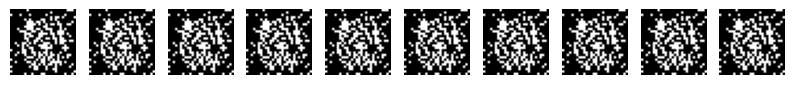

 20%|██        | 50/250 [15:22<1:01:27, 18.44s/it]

epoch : 50/250 | Generator_loss : 3.0286073684692383 | Discriminator_loss : 0.3763893246650696


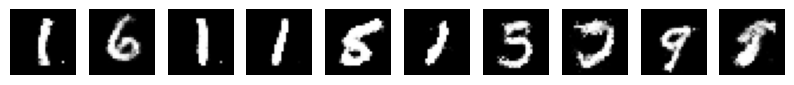

 40%|████      | 100/250 [30:32<45:51, 18.34s/it]

epoch : 100/250 | Generator_loss : 4.240748405456543 | Discriminator_loss : 0.15280255675315857


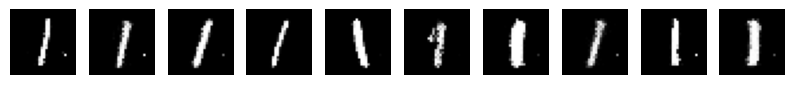

 60%|██████    | 150/250 [45:44<30:44, 18.45s/it]

epoch : 150/250 | Generator_loss : 4.3895158767700195 | Discriminator_loss : 0.10124977678060532


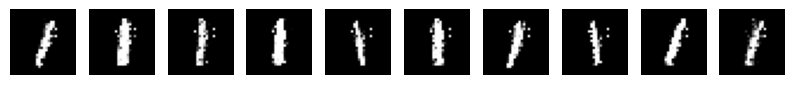

 80%|████████  | 200/250 [1:00:57<15:30, 18.62s/it]

epoch : 200/250 | Generator_loss : 11.244601249694824 | Discriminator_loss : 0.007795525249093771


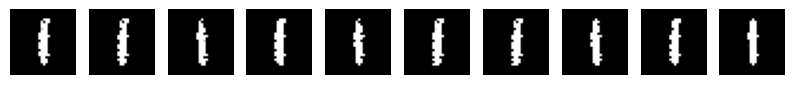

100%|██████████| 250/250 [1:16:06<00:00, 18.27s/it]


In [7]:
generator, discriminator, generator_loss, discriminator_loss = train_gan (
          generator,
          discriminator,
          generator_optimizer,
          discriminator_optimizer,
          50,
          50,
          250,
          train_loader,
          test_loader,
          latent_dim,
          device
)

### training gans is usually unstable. In the result we can clearly see a case called mode collapse where our generator always tries to generate same image because the image it has generated gives less loss. So The output from the generator is narrowed to a single space.